# FINM 36700
# HOMEWORK #3

## Imports & data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

#importing the data
data = pd.read_excel('/Users/kaiwentay/Documents/GitHub/finm-portfolio-2023/data/barnstable_analysis_data.xlsx', 'data')
data = data.set_index('date')
des = pd.read_excel('/Users/kaiwentay/Documents/GitHub/finm-portfolio-2023/data/barnstable_analysis_data.xlsx', 'descriptions')
data.fillna(method='ffill', inplace=True)
data['SPX ER'] = data['SPX'] - data['TB1M']
data.head()

,SPX,TB1M,SPX ER
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033296,0.002612,-0.035908
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


## section 1
### part 1(a)

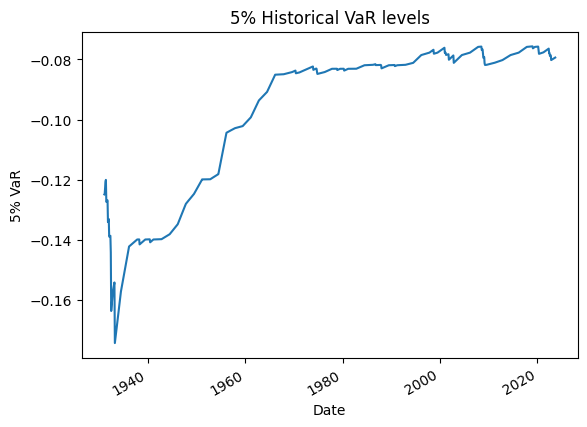

In [2]:
hist_var = data['SPX ER'].shift()
hist_var = hist_var.expanding(min_periods = 60)
hist_var = hist_var.quantile(0.05)

hist_var.plot()
plt.title('5% Historical VaR levels')
plt.ylabel('5% VaR')
plt.xlabel('Date')
plt.show()

### part 1(b)

In [3]:
breach_count = sum(data['SPX ER'] < hist_var)
len_data = len(hist_var.dropna())
breach_pct = breach_count / len_data
print(f'Percentage of periods breached: {breach_pct*100}%\n(number of breaches: {breach_count}, length of dataset: {len_data})')

Percentage of periods breached: 3.147482014388489%
(number of breaches: 35, length of dataset: 1112)


### part 1(c)
There are a few drawbacks to historical VaR values:
* Given that everything is reliant on historical data, you are unable to capture black swan events happening, since they've never happened in history or happens so rarely it isn't captured in your dataset period.

* Sufficiency of data is an issue: if there is insufficient data, your VaR values are not well tested or not as accurate. 

* There isn't any weightage or variability to which points are more important depending on your situation (i.e. COVID-19 is a fringe event that is unlikely to happen often but causes massive swings in the market, but adding that into your dataset might cause your VaR to be overly cautious unnecessarily based on historical info.)

* Similarly, too much weight is given to momentum of stocks and not enough to swings e.g. if your stock has been rallying your VaR values are biased towards one end of the returns spectrum. Also, if a stock swings down 50% the sample of historical VaR is biased downwards since weightage is equal. 

## section 1
### part 2(a)

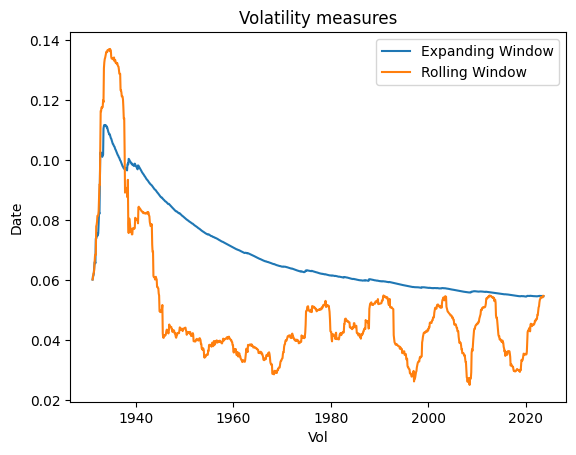

In [4]:
def expandingseries(data, excess_return_string, n = 60):
    cum_sum = (data[excess_return_string] ** 2).cumsum()
    data['Expanding Variance'] = (1 / np.arange(1, len(data) + 1)) * cum_sum
    data['Expanding Volatility'] = data['Expanding Variance'] ** 0.5
    data['Expanding Variance'].iloc[:n] = None
    data['Expanding Volatility'].iloc[:n] = None
    return data

def rollingseries(data, excess_return_string, n = 60):
    squareddata = data[excess_return_string] ** 2
    data['Rolling Variance'] = (squareddata).shift(1).rolling(60).mean()
    data['Rolling Volatility'] = data['Rolling Variance'] ** 0.5
    data['Rolling Variance'].iloc[:n] = None
    data['Rolling Volatility'].iloc[:n] = None
    return data

data = expandingseries(data, 'SPX ER')
data = rollingseries(data, 'SPX ER')

plt.plot(data['Expanding Volatility'], label = 'Expanding Window')
plt.plot(data['Rolling Volatility'], label = 'Rolling Window')
plt.title('Volatility measures')
plt.xlabel('Vol')
plt.ylabel('Date')
plt.legend()
plt.show()

### part 2(b)

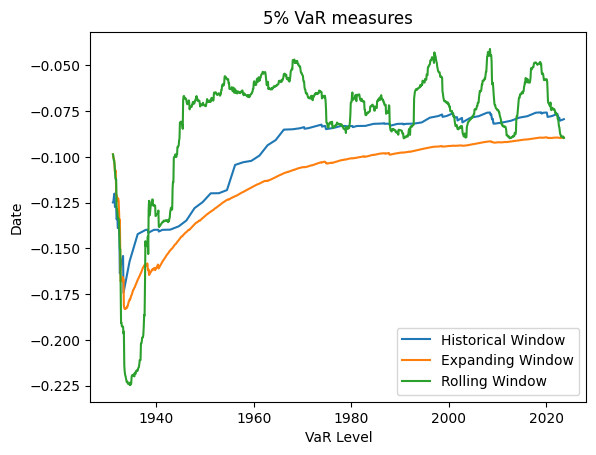

In [5]:
VaR_data = pd.DataFrame()
VaR_data['5% Historical VaR'] = hist_var
VaR_data['5% Expanding VaR'] = -1.64 * data['Expanding Volatility']
VaR_data['5% Rolling VaR'] = -1.64 * data['Rolling Volatility']

plt.plot(VaR_data['5% Historical VaR'], label = 'Historical Window')
plt.plot(VaR_data['5% Expanding VaR'], label = 'Expanding Window')
plt.plot(VaR_data['5% Rolling VaR'], label = 'Rolling Window')
plt.title('5% VaR measures')
plt.xlabel('VaR Level')
plt.ylabel('Date')
plt.legend()
plt.show()

### part 2(c)

In [6]:
for column_name, column in VaR_data.items():
    breach_count = sum(data['SPX ER'] < column)
    len_data = len(column.dropna())
    breach_pct = breach_count / len_data
    print(f'Column: {column_name}')
    print(f'Percentage of periods breached: {breach_pct * 100}%\n(number of breaches: {breach_count}, length of dataset: {len_data})')
    print()

Column: 5% Historical VaR
Percentage of periods breached: 3.147482014388489%
(number of breaches: 35, length of dataset: 1112)

Column: 5% Expanding VaR
Percentage of periods breached: 1.7985611510791366%
(number of breaches: 20, length of dataset: 1112)

Column: 5% Rolling VaR
Percentage of periods breached: 5.0359712230215825%
(number of breaches: 56, length of dataset: 1112)



### part 2(c)
Intuitively before running the numbers, it should be predictable easily historical would have more breaches than expanding window given the overall higher levels in general. On the other hand, rolling window is more of a wildcard although I believe it will have larger number of breaches, as it is more influenced by recent observations making it susceptible to being caught by overcorrection on the positive end (markets have more positives than negatives).

Our observations confirm this. Rolling VaR produces the highest breaches. Similarly, Historical seems to breach more than Expanding.

Our use cases would depend out what we are out to do:
* Rolling would be quicker to react to changes in volatility but leads to a lot of correction if we would to adjust portfolios based on it (i.e. very reactionary)
* Historical/Expanding would be better if we prefer not to overreact to tail risk events and adjust sparingly. Although it suffice to say that these seem a bit more inferior as they do not allow us to place hedges fast enough so the confidence interval might need to be adjusted. 

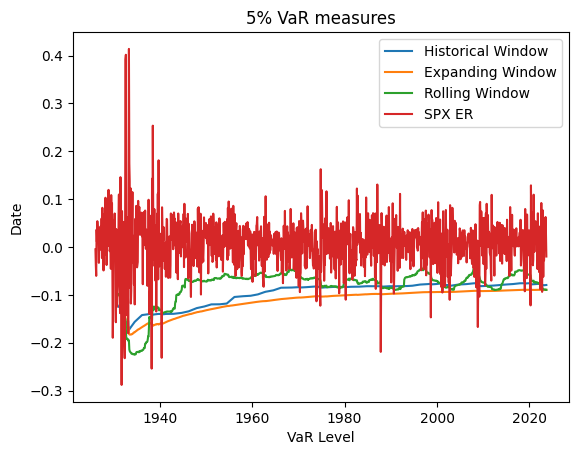

In [7]:
plt.plot(VaR_data['5% Historical VaR'], label = 'Historical Window')
plt.plot(VaR_data['5% Expanding VaR'], label = 'Expanding Window')
plt.plot(VaR_data['5% Rolling VaR'], label = 'Rolling Window')
plt.plot(data['SPX ER'], label = 'SPX ER')
plt.title('5% VaR measures')
plt.xlabel('VaR Level')
plt.ylabel('Date')
plt.legend()
plt.show()

## section 1
### part 3

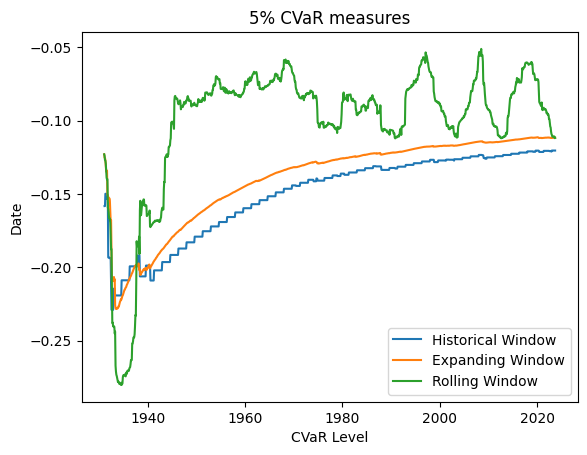

In [11]:
from scipy.stats import norm

historic_CVaR = []

for i in range(len(data)):
    if i < 61:
        historic_CVaR.append(np.nan)
    else:
        window = data[['SPX ER']][:i-1]
        CVaR = window[window < window.quantile(0.05)]['SPX ER'].mean()
        historic_CVaR.append(CVaR)

CVaR_data = pd.DataFrame()
CVaR_data['5% Expanding CVaR'] = data['Expanding Volatility'] * norm.pdf(1.65) / 0.05 *-1
CVaR_data['5% Rolling CVaR'] = data['Rolling Volatility'] * norm.pdf(1.65) / 0.05 * -1
CVaR_data['5% Historical CVaR'] = historic_CVaR

plt.plot(CVaR_data['5% Historical CVaR'], label = 'Historical Window')
plt.plot(CVaR_data['5% Expanding CVaR'], label = 'Expanding Window')
plt.plot(CVaR_data['5% Rolling CVaR'], label = 'Rolling Window')
plt.title('5% CVaR measures')
plt.xlabel('CVaR Level')
plt.ylabel('Date')
plt.legend()
plt.show()

## section 3
### part 1(a)

In [ ]:
summarystats = 